In [1]:
import numpy as np
import keras
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random as r
import math
import keras
import cv2

from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import np_utils, plot_model
import itertools
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Data Preparation

In [2]:
def get_test_files(file_dir):

    images = []   
    subfolders = []
    file_array = []
    file_img_list = []
    file_all_img = []
 
    for dirPath, dirNames, fileNames in os.walk(file_dir):
        
        names = []
        for name in fileNames:
            names.append(os.path.join(dirPath, name))
        for name in dirNames:
            subfolders.append(os.path.join(dirPath, name))
        r.shuffle(names)
        if names != []:
            images.append(names)

    mincount = float("Inf")
    for num_folder in subfolders:
        n_img = len(os.listdir(num_folder))
        
        if n_img < mincount:
            mincount = n_img

    for i in range(len(images)):
        images[i] = images[i][0:mincount]
        file_img_list.append([])
        file_img_list[i] = images[i][0:]

    for i in range(len(images)):
        file_all_img.extend(file_img_list[i])

    file_labels = []
    for count in range(len(subfolders)):
        file_labels = np.append(file_labels, len(file_img_list[0]) * [count])
        #print(len(train_labels))
            
    file_array = np.array([file_all_img, file_labels])
    file_array = file_array[:, np.random.permutation(file_array.shape[1])].T
    
    file_img = list(file_array[:, 0])
    file_labels = list(file_array[:, 1])
    file_labels = [int(float(i)) for i in file_labels]
    
    # 返回图片路径列表和对应标签列表
    return file_img, file_labels

In [3]:
def get_train_files(file_dir, train_size):

    images = []   
    subfolders = []
    train_array = []
    test_array = []
    train_img_list = []
    test_img_list = []
    train_all_img = []
    test_all_img = []
 
    for dirPath, dirNames, fileNames in os.walk(file_dir):
        
        names = []
        for name in fileNames:
            names.append(os.path.join(dirPath, name))
        for name in dirNames:
            subfolders.append(os.path.join(dirPath, name))
        r.shuffle(names)
        if names != []:
            images.append(names)

    mincount = float("Inf")
    for num_folder in subfolders:
        n_img = len(os.listdir(num_folder))
        
        if n_img < mincount:
            mincount = n_img

    for i in range(len(images)):
        images[i] = images[i][0:mincount]
        train_img_list.append([])
        test_img_list.append([])
        train_num = math.ceil(len(images[i]) * train_size)
        train_img_list[i] = images[i][0:train_num]
        test_img_list[i] = images[i][train_num:]

    for i in range(len(images)):
        train_all_img.extend(train_img_list[i])

    for i in range(len(images)):
        test_all_img.extend(test_img_list[i])

    train_labels = []
    test_labels = []
    for count in range(len(subfolders)):
        train_labels = np.append(train_labels, len(train_img_list[0]) * [count])
        #print(len(train_labels))
    for count in range(len(subfolders)):
        test_labels = np.append(test_labels, len(test_img_list[0]) * [count])
            
    train_array = np.array([train_all_img, train_labels])
    train_array = train_array[:, np.random.permutation(train_array.shape[1])].T
    test_array = np.array([test_all_img, test_labels])
    test_array = test_array[:, np.random.permutation(test_array.shape[1])].T
    
    train_img = list(train_array[:, 0])
    train_labels = list(train_array[:, 1])
    train_labels = [int(float(i)) for i in train_labels]
    
    test_img = list(test_array[:, 0])
    test_labels = list(test_array[:, 1])
    test_labels = [int(float(i)) for i in test_labels]
    
    # 返回图片路径列表和对应标签列表
    return train_img, train_labels, test_img, test_labels

In [4]:
target_train_img, target_train_labels ,val_img, val_labels = get_train_files('7x9_1', train_size = 0.2)
target_test_img, target_test_labels = get_test_files('7x9_3')

In [5]:
train_images = []
for img in target_train_img:
    img = Image.open(img)
    img = image.img_to_array(img)
    train_images.append(img)

x_train = np.array(train_images)
y_train = np.array(target_train_labels)

In [6]:
val_images = []
for img in val_img:
    img = Image.open(img)
    img = image.img_to_array(img)
    val_images.append(img)

x_val = np.array(val_images)
y_val = np.array(val_labels)

In [7]:
test_images = []
for img in target_test_img:
    img = Image.open(img)
    img = image.img_to_array(img)
    test_images.append(img)

x_test = np.array(test_images)
y_test = np.array(target_test_labels)

## Normalized

In [8]:
x_train /= 255
x_val /= 255
x_test /= 255
y_train_onehot = np_utils.to_categorical(y_train)
y_val_onehot = np_utils.to_categorical(y_val)
y_test_onehot = np_utils.to_categorical(y_test)

## One case train 

In [9]:
model = Sequential()
#卷積層1
model.add(Conv2D(filters=63,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(9,7,1), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
#卷積層2
model.add(Conv2D(filters=126,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
#卷積層3
model.add(Conv2D(filters=252,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))
#平坦層
model.add(Flatten())
#全連接層
model.add(Dense(504, activation='relu'))
#輸出層
model.add(Dense(6,activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 7, 35)          350       
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 7, 35)          140       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 70)          22120     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 7, 70)          280       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 7, 140)         88340     
_________________________________________________________________
batch_normalization_3

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
train_history=model.fit(x=x_train, 
                        y=y_train_onehot,validation_data=(x_val, y_val_onehot), 
                        epochs=50, batch_size=64,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 96 samples, validate on 366 samples
Epoch 1/50
96/96 [==============================] - 1s 12ms/step - loss: 3.8194 - acc: 0.2708 - val_loss: 5.3141 - val_acc: 0.4454
Epoch 2/50
96/96 [==============================] - 0s 4ms/step - loss: 4.3021 - acc: 0.5938 - val_loss: 4.4522 - val_acc: 0.6230
Epoch 3/50
96/96 [==============================] - 0s 4ms/step - loss: 3.5495 - acc: 0.7188 - val_loss: 3.1620 - val_acc: 0.7514
Epoch 4/50
96/96 [==============================] - 0s 4ms/step - loss: 2.6974 - acc: 0.8229 - val_loss: 2.8859 - val_acc: 0.7842
Epoch 5/50
96/96 [==============================] - 0s 4ms/step - loss: 2.7017 - acc: 0.8229 - val_loss: 3.2985 - val_acc: 0.7158
Epoch 6/50
96/96 [==============================] - 0s 4ms/step - loss: 2.7060 - acc: 0.8229 - val_loss: 3.3430 - val_acc: 0.7213
Epoch 7/50
96/96 [==============================] - 0s 4ms/step - loss: 2.7437 - acc: 0.8229 - val_loss: 3.0526 - val_acc: 0.7

## Transfer Train 

In [11]:
model_trans = Sequential()
#卷積層1
model_trans.add(Conv2D(filters=63,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(9,7,1), 
                 activation='relu', name = "conv_1"))
model_trans.add(BatchNormalization(name = "bn_1"))
model_trans.add(Dropout(0.25, name = "DP1"))
#卷積層2
model_trans.add(Conv2D(filters=126,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu', name = "conv_2"))
model_trans.add(BatchNormalization(name = "bn_2"))
model_trans.add(Dropout(0.25, name = "DP2"))
#卷積層3
model_trans.add(Conv2D(filters=252,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu', name = "conv_3"))
model_trans.add(BatchNormalization(name = "bn_3"))

model_trans.add(Dropout(0.25, name = "DP3"))
#平坦層
model_trans.add(Flatten(name = "Flat"))
#全連接層
model_trans.add(Dense(504, activation='relu', name = "dense_1"))
#輸出層
model_trans.add(Dense(6,activation='softmax', name = "dense_2"))

model_trans.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) 

model_trans.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 9, 7, 35)          350       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 9, 7, 35)          140       
_________________________________________________________________
conv_2 (Conv2D)              (None, 9, 7, 70)          22120     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 9, 7, 70)          280       
_________________________________________________________________
conv_3 (Conv2D)              (None, 9, 7, 140)         88340     
_________________________________________________________________
bn_3 (BatchNormalization)    (None, 9, 7, 140)         560       
_________________________________________________________________
DP (Dropout)                 (None, 9, 7, 140)         0         
__________

In [12]:
model_trans.load_weights('models/7x9_m1/pre/7x9model_weights.h5', by_name = True)

train_history_trans = model_trans.fit(x=x_train, 
                                      y=y_train_onehot,validation_data=(x_val, y_val_onehot), 
                                      epochs=50, batch_size=64,verbose=1)

Train on 96 samples, validate on 366 samples
Epoch 1/50
96/96 [==============================] - 1s 12ms/step - loss: 3.0605 - acc: 0.7812 - val_loss: 1.8831 - val_acc: 0.8415
Epoch 2/50
96/96 [==============================] - 0s 4ms/step - loss: 1.7308 - acc: 0.8750 - val_loss: 1.4980 - val_acc: 0.8852
Epoch 3/50
96/96 [==============================] - 0s 4ms/step - loss: 0.8439 - acc: 0.9479 - val_loss: 1.3533 - val_acc: 0.8989
Epoch 4/50
96/96 [==============================] - 0s 4ms/step - loss: 0.8412 - acc: 0.9479 - val_loss: 1.2866 - val_acc: 0.8989
Epoch 5/50
96/96 [==============================] - 0s 4ms/step - loss: 0.7882 - acc: 0.9479 - val_loss: 1.2101 - val_acc: 0.8989
Epoch 6/50
96/96 [==============================] - 0s 4ms/step - loss: 0.6928 - acc: 0.9479 - val_loss: 1.1101 - val_acc: 0.9126
Epoch 7/50
96/96 [==============================] - 0s 4ms/step - loss: 0.5396 - acc: 0.9583 - val_loss: 1.0252 - val_acc: 0.9235
Epoch 8/50
96/96 [==========================

## One case predict 

In [13]:
scores = model.evaluate(x_test,y_test_onehot)
print()
print('accuracy=',scores[1])

1374/1374 [==============================] - 1s 511us/step

accuracy= 0.8253275104832267


In [14]:
import pandas as pd
pose = [{"姿勢":"仰臥"},{"姿勢":"俯臥"},{"姿勢":"右側"},{"姿勢":"左側"},{"姿勢":"坐姿"},{"姿勢":"未知"}]
pose_df = pd.DataFrame(pose)

prediction = model.predict_classes(x_test)
pred = pd.crosstab(y_test, prediction, rownames=['label'], colnames=['predict'])

com = pd.concat([pose_df, pred], axis = 1)
com

,姿勢,0,1,2,3,4
0,仰臥,228,0,0,0,1
1,俯臥,0,229,0,0,0
2,右側,0,0,229,0,0
3,左側,1,0,1,224,3
4,坐姿,0,0,5,0,224
5,未知,2,13,84,5,125


## Transfer predict 

In [15]:
scores = model_trans.evaluate(x_test,y_test_onehot)
print()
print('accuracy=',scores[1])

1374/1374 [==============================] - 1s 474us/step

accuracy= 0.9534206689705494


In [16]:
import pandas as pd
prediction = model_trans.predict_classes(x_test)
pred_trans = pd.crosstab(y_test, prediction, rownames=['label'], colnames=['predict'])

com_trans = pd.concat([pose_df, pred_trans], axis = 1)
com_trans

,姿勢,0,1,2,3,4,5
0,仰臥,228,0,0,0,1,0
1,俯臥,0,227,0,1,0,1
2,右側,0,0,227,0,0,2
3,左側,0,0,0,229,0,0
4,坐姿,0,0,7,0,218,4
5,未知,0,0,14,26,8,181


## Graphically display

In [17]:
def show_train_history(train_history, title, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(title)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

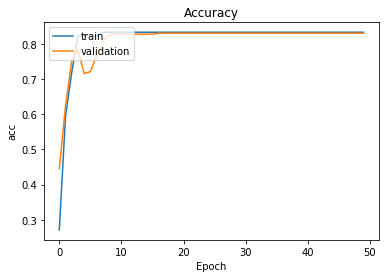

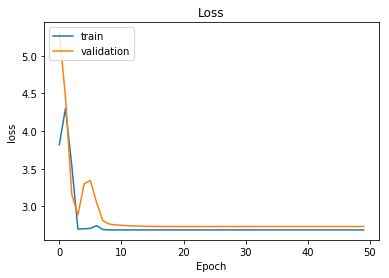

In [18]:
show_train_history(train_history, 'Accuracy', 'acc', 'val_acc')
show_train_history(train_history, 'Loss', 'loss', 'val_loss')

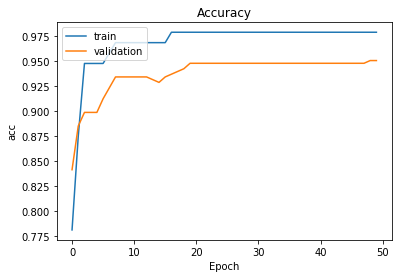

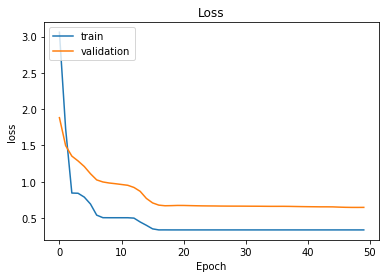

In [19]:
show_train_history(train_history_trans, 'Accuracy', 'acc', 'val_acc')
show_train_history(train_history_trans, 'Loss', 'loss', 'val_loss')

## Save Model

In [20]:
model.save('models/7x9_m1/trans/7x9trans_model.h5')

In [21]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file('models/7x9_m1/trans/7x9trans_model.h5')
tfmodel = converter.convert()
open ('models/7x9_m1/trans/7x9trans_model.tflite' , "wb") .write(tfmodel)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 22 variables.
INFO:tensorflow:Converted 22 variables to const ops.


10335212

In [22]:
df = pd.DataFrame({'label':y_test, 'predict':prediction})
df[(df.label==2)&(df.predict==4)]

,label,predict


In [23]:
def print_error_img(PictureNum):
    img = x_test[PictureNum]*255
    img = image.array_to_img(img)
    plt.figure(figsize=(2,2))
    plt.imshow(img, cmap = 'gray')
    title = 'label=' + str(y_test[PictureNum]) + '; predict=' + str(prediction[PictureNum])
    plt.xticks([]); plt.yticks([])
    plt.title(title)
    plt.show()

In [24]:
picturenum = df[(df.label==2)&(df.predict==4)].index.values.tolist()
picturenum

[]

In [25]:
for num in picturenum:
    print_error_img(num)

In [26]:
img = x_test[4]*255
img = image.array_to_img(img)

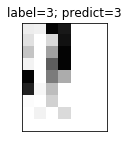

In [27]:
plt.figure(figsize=(2,2))
plt.imshow(img, cmap = 'gray')
title = 'label=' + str(y_test[4]) + '; predict=' + str(prediction[4])
plt.xticks([]); plt.yticks([])
plt.title(title)
plt.show()